In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.metrics import *

In [2]:
#import data
bnp_data = pd.read_csv("../cleaned_data.csv")
bnp_data = add_features(bnp_data, window_sizes=[5, 10])
bnp_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Log Return,ma_close_5,ma_volume_5,ma_close_10,ma_volume_10,RSI,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10
0,2013-01-02,22.753109,44.459999,44.564999,43.419998,43.930000,3604846.0,0.000000,22.948605,3109596.8,23.08883,3775578.6,67.456112,23.546244,22.350967,23.758032,22.419628
1,2013-01-03,22.753109,44.459999,44.544998,44.014999,44.240002,1719620.0,0.000000,22.948605,3109596.8,23.08883,3775578.6,67.456112,23.546244,22.350967,23.758032,22.419628
2,2013-01-04,22.714727,44.384998,44.720001,43.955002,44.360001,1969483.0,-0.001688,22.948605,3109596.8,23.08883,3775578.6,67.456112,23.546244,22.350967,23.758032,22.419628
3,2013-01-07,23.136936,45.209999,46.064999,45.119999,45.250000,4186011.0,0.018417,22.948605,3109596.8,23.08883,3775578.6,67.456112,23.546244,22.350967,23.758032,22.419628
4,2013-01-08,23.385145,45.695000,46.555000,45.064999,45.154999,4068024.0,0.010671,22.948605,3109596.8,23.08883,3775578.6,67.456112,23.546244,22.350967,23.758032,22.419628


In [3]:
features=bnp_data.columns[1:]
features

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log Return',
       'ma_close_5', 'ma_volume_5', 'ma_close_10', 'ma_volume_10', 'RSI',
       'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10',
       'bollinger_lower_10'],
      dtype='object')

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

target = bnp_data[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_bnp = scaler.fit_transform(bnp_data[features])
scaled_bnp = pd.DataFrame(scaled_bnp, columns=features)

In [5]:
gap = 100  # Gap between each subset

total_samples = len(scaled_bnp)
train_size = int(0.58 * total_samples)
test_size = int(0.17 * total_samples)
validation_size = int(0.17 * total_samples)

train,test,validation=data_splitting(scaled_bnp,train_size,test_size,validation_size,gap)

<h2>LSTM Model</h2>

In [6]:
timesteps = 10
X_train, y_train = create_sequences(train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(validation, target_column='Adj Close', timesteps=timesteps)

In [8]:
# Build and train the LSTM model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,241 (16.57 KB)

 Trainable params: 4,241 (16.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4562 - val_loss: 0.2132
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1547 - val_loss: 0.0870
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0566 - val_loss: 0.0383
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - val_loss: 0.0277
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0189
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0149
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0160
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0060
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [9]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 3.3119
NSE: 0.8613


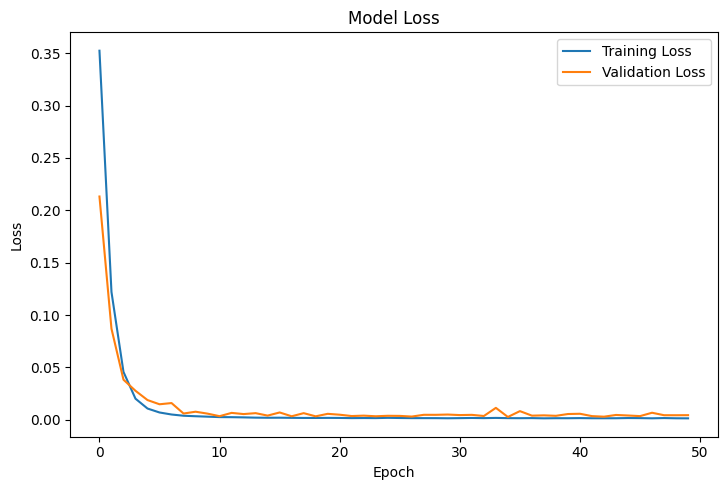

In [10]:
plot_learning_curves(history)

The gap between training and validation loss shows the model fits the training data too well but struggles to generalize.

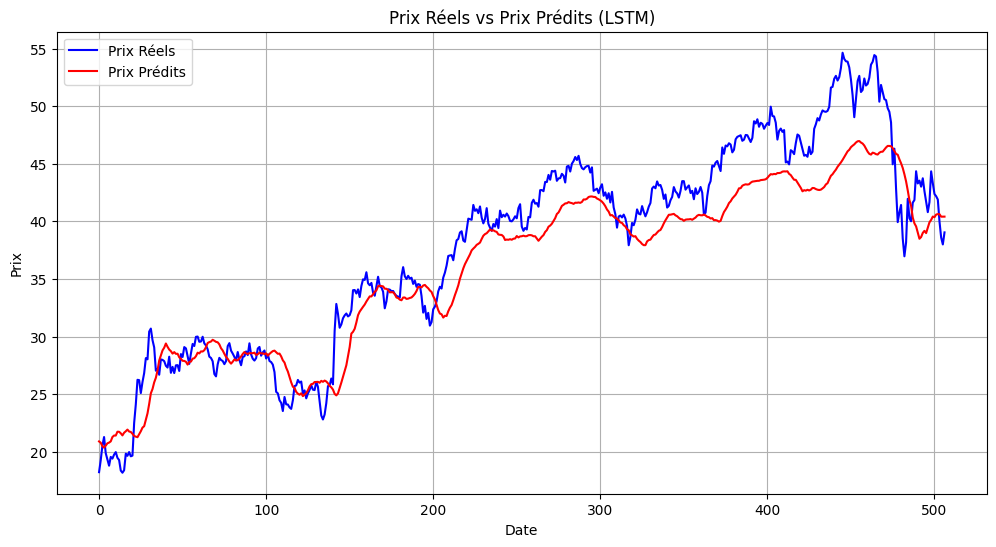

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2> GRU Model</h2>

In [12]:
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.summary()

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 16)         │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4161 - val_loss: 0.1983
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1600 - val_loss: 0.0820
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0641 - val_loss: 0.0378
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - val_loss: 0.0223
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0156
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0072
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [14]:
# Predict and evaluate
y_pred = gru_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 3.2761
NSE: 0.8643


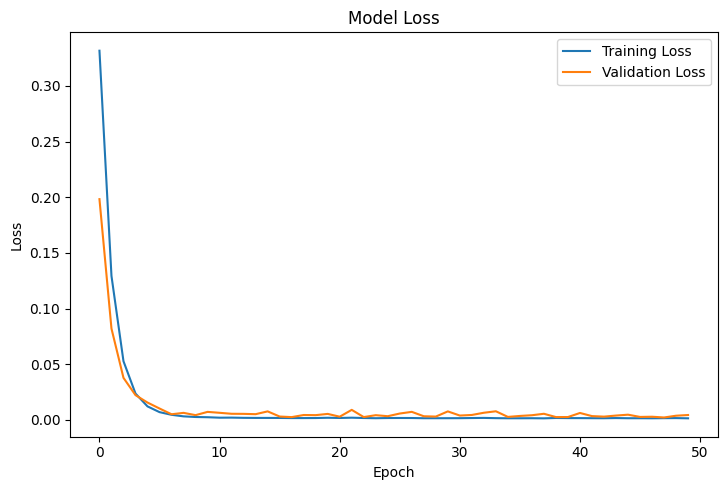

In [15]:
plot_learning_curves(gru_history)

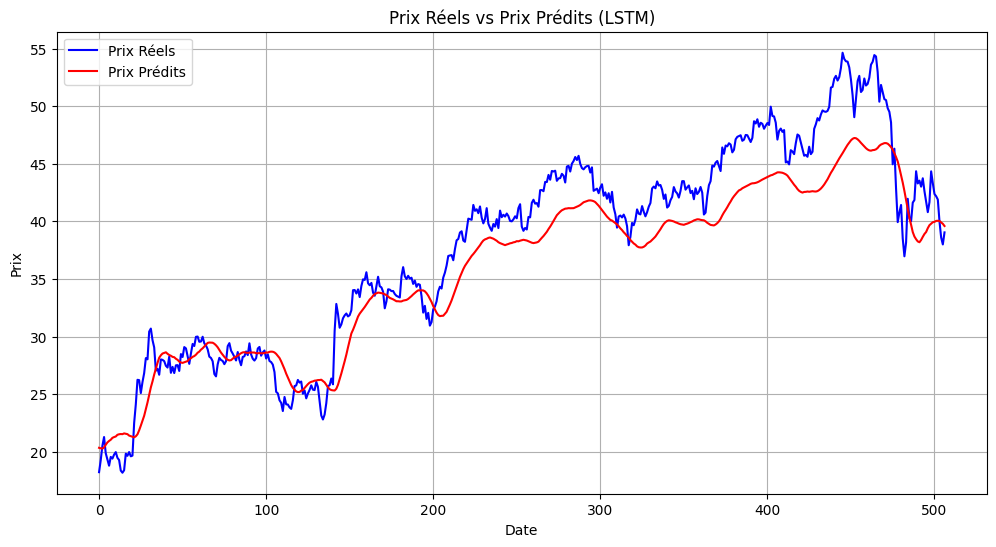

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>CNN Model</h2>

In [17]:
cnn1d_model = build_cnn1d_model((X_train.shape[1], X_train.shape[2]))  
cnn1d_model.summary()

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,789 (73.39 KB)

 Trainable params: 18,789 (73.39 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
cnn1d_history = cnn1d_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0372 - val_loss: 0.0300
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0313
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0258
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0221
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0221
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0152
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0151
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0120
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0117
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0106
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0146
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

In [19]:
# Predict and evaluate
y_pred = cnn1d_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 4.0257
NSE: 0.7950


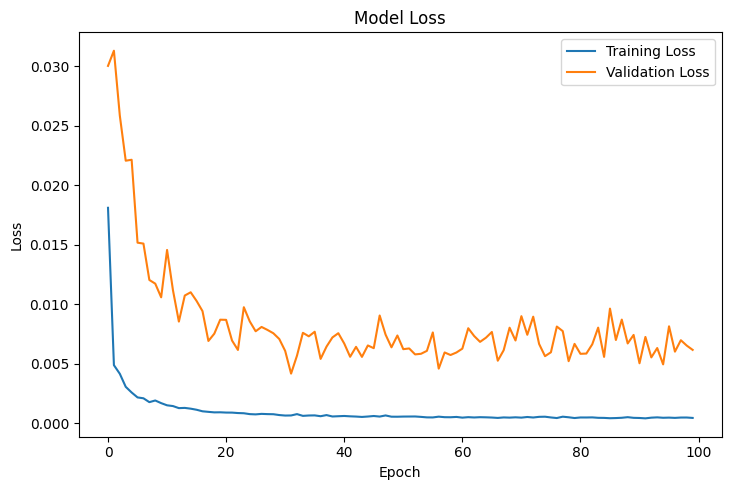

In [20]:
plot_learning_curves(cnn1d_history)

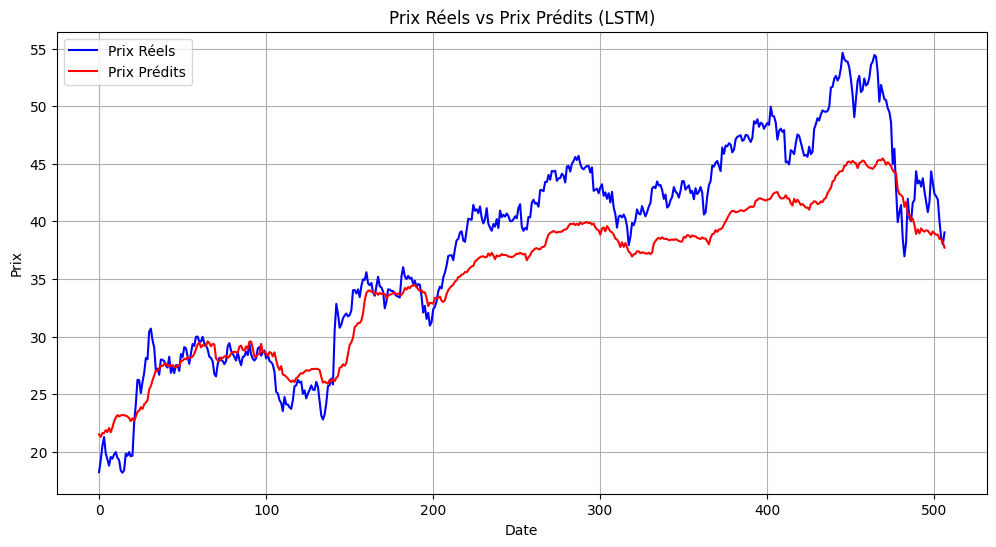

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()